In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
path = os.getcwd()
data = path + '/dataset/bank/bank-full.csv'
df = pd.read_csv(data, sep=';')
print(f'size of the data --> {df.shape}')
df.head()

size of the data --> (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
# create table listing column types etc
df_info = pd.DataFrame([df.columns,df.dtypes, df.isna().sum(), df.nunique()])
df_info = df_info.T
df_info.columns = ['column','dtype','NA_count', 'unique_count']
print(f'check for duplicates --> {df.duplicated().sum()}')
df_info

check for duplicates --> 0


,column,dtype,NA_count,unique_count
0,age,int64,0,77
1,job,object,0,12
2,marital,object,0,3
3,education,object,0,4
4,default,object,0,2
5,balance,int64,0,7168
6,housing,object,0,2
7,loan,object,0,2
8,contact,object,0,3
9,day,int64,0,31


## Bank Client data:
1 - age: (numeric)

2 - job: type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital: marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education: (categorical: primary, secondary, tertiary and unknown)

5 - default: has defaulted in credit? (categorical: 'no','yes','unknown')

6 - balance: bank balance of the individual.

7 - housing: has housing loan? (categorical: 'no','yes','unknown')

8 - loan: has personal loan? (categorical: 'no','yes','unknown')

## Related with the last contact of the current campaign:
9 - contact: contact communication type (categorical: 'unknwon','cellular','telephone') 

10 - day: last contact day of the month (numerical: [1,31])

11 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

12 - duration: last contact duration, in seconds (numerical). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

## Other attributes:
13 - campaign: number of contacts performed during this campaign and for this client (numeric [1,44], includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: 'unknown','failure','other','success')

Output variable (desired target):

17 - y - has the client subscribed a term deposit? (binary: 'yes','no')

## Term Deposits


A term deposit is a fixed-term investment that includes the deposit of money into an account at a financial institution. Term deposit investments usually carry short-term maturities ranging from one month to a few years and will have varying levels of required minimum deposits.

# Distribution of categorical

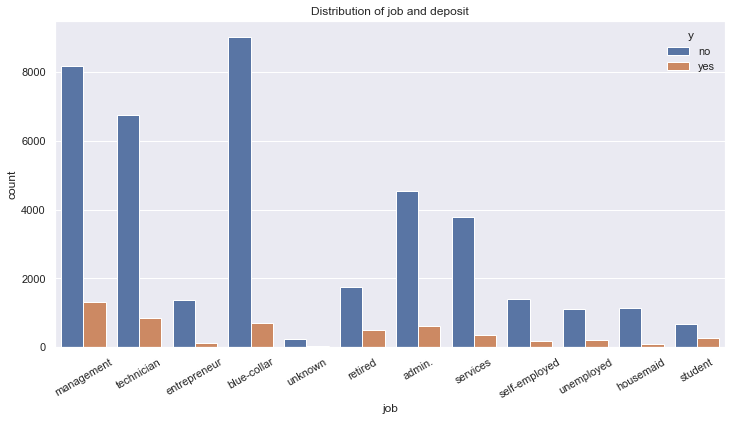

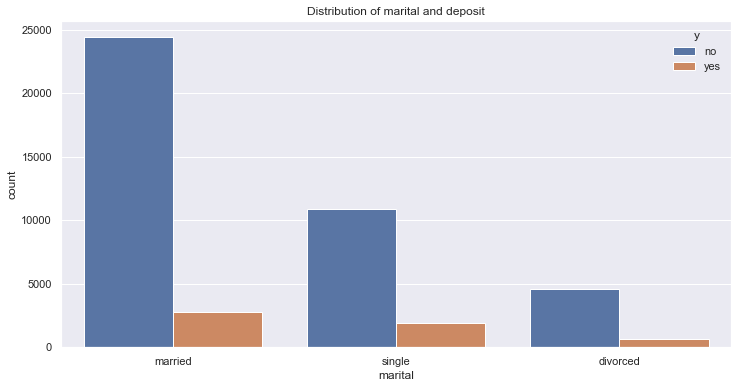

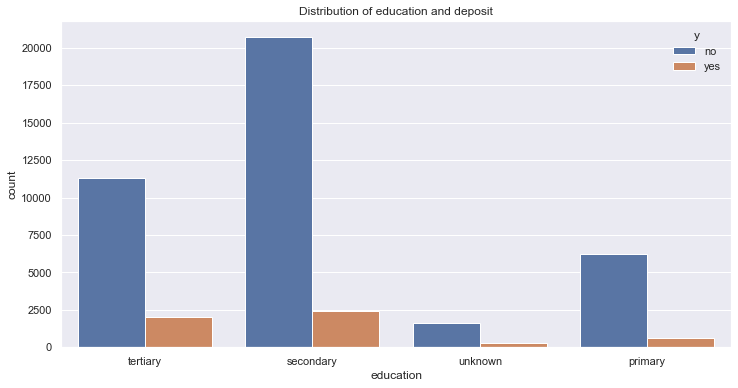

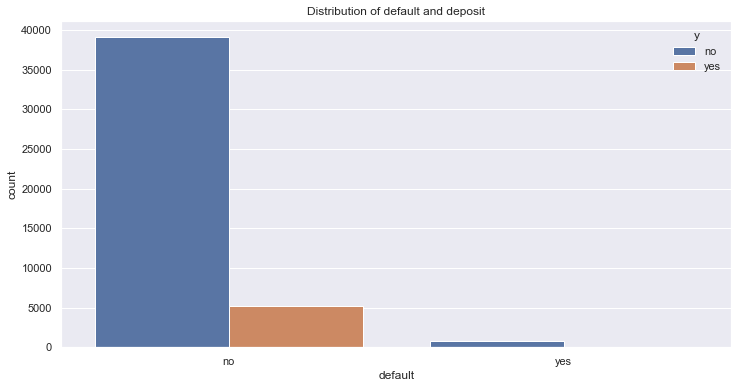

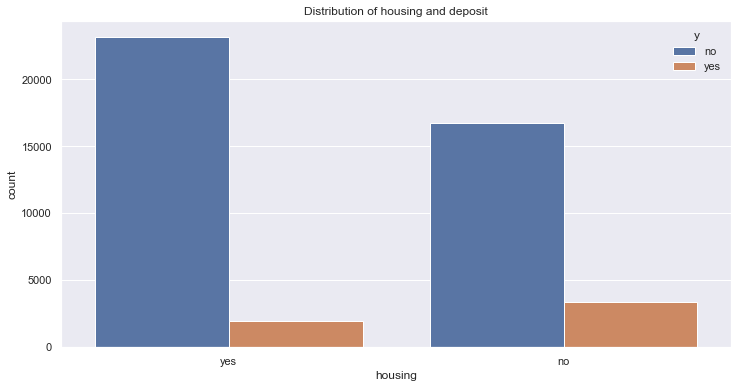

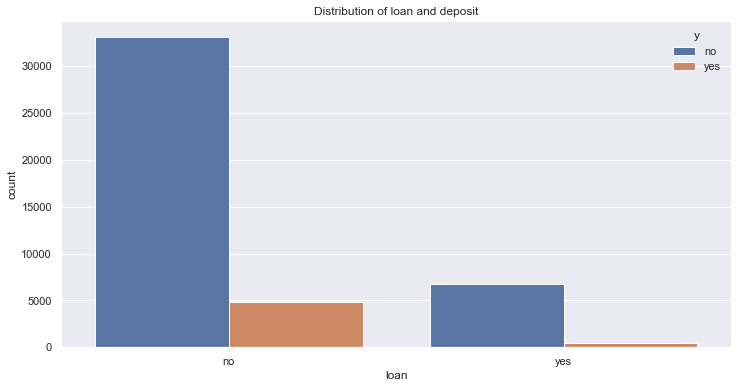

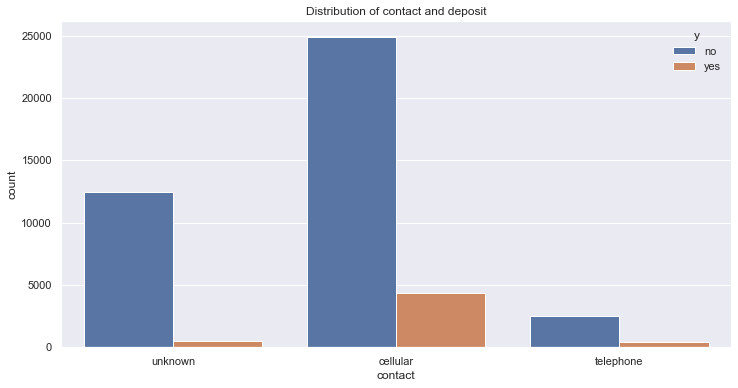

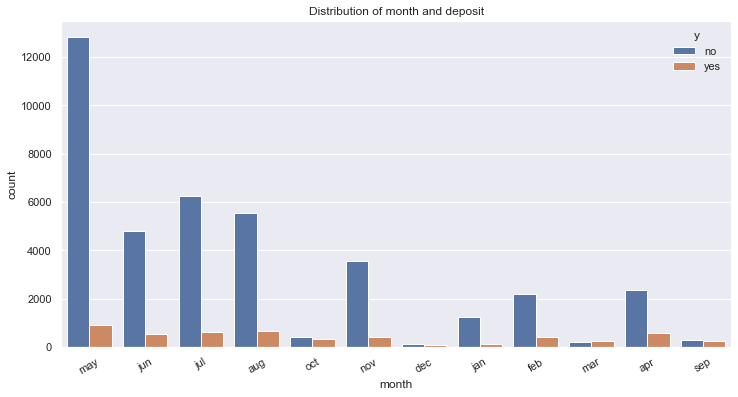

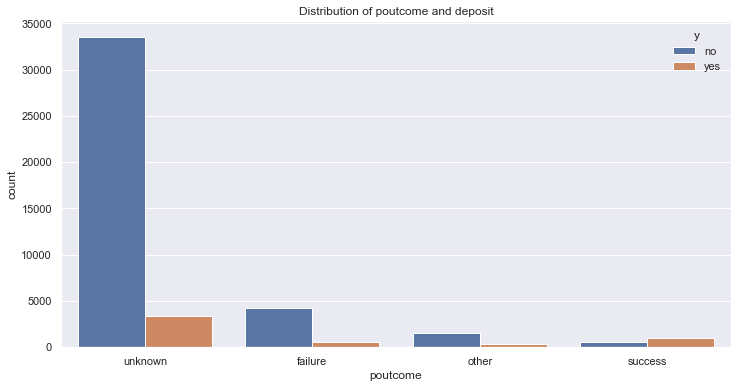

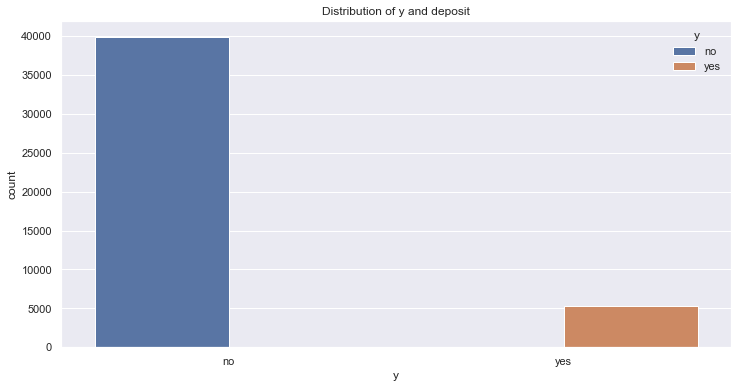

In [60]:
'''plot bar chart for categorical variables'''
for col in df.select_dtypes(include='object').columns:
    sns.countplot(data=df, x=str(col), hue='y').set(title='Distribution of {} and deposit'.format(col))
    if len(df[col].unique()) > 5:       # rotate ticks to avoid overlapping
        plt.xticks(rotation=30)
    sns.set(rc={'figure.figsize':(12,6)})
    plt.show()

# Distribution of numerical data

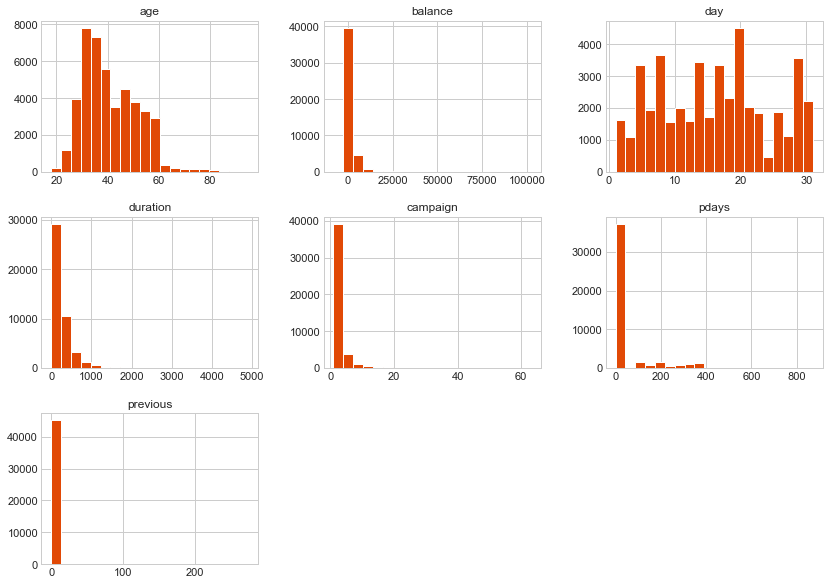

In [5]:
plt.style.use('seaborn-whitegrid')

df.hist(bins=20, figsize=(14,10), color='#E14906')
plt.show()

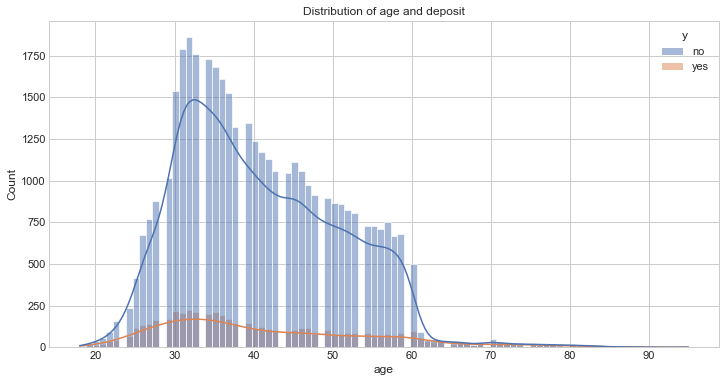

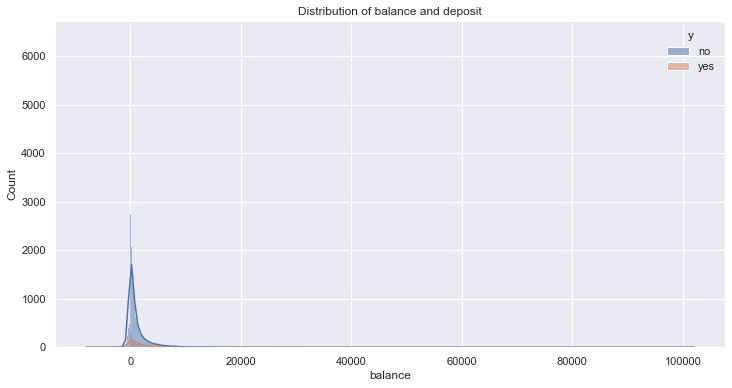

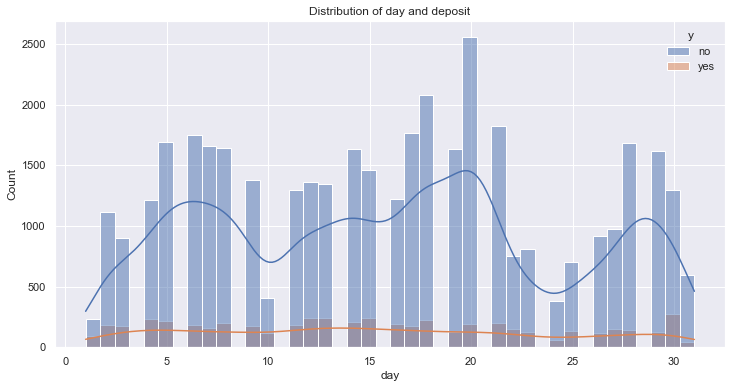

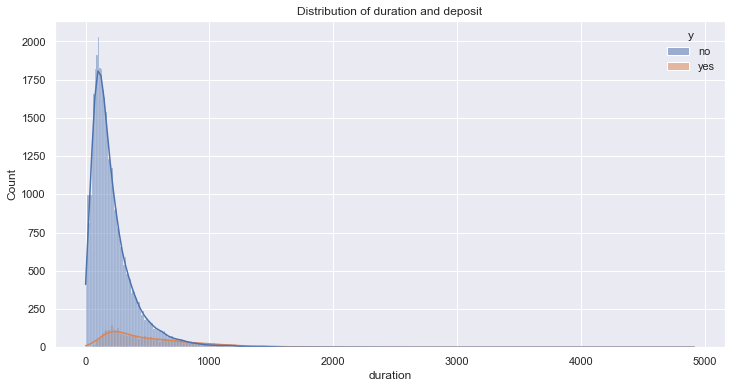

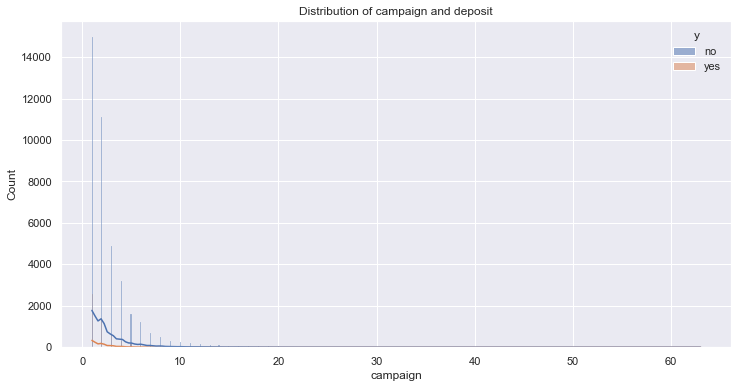

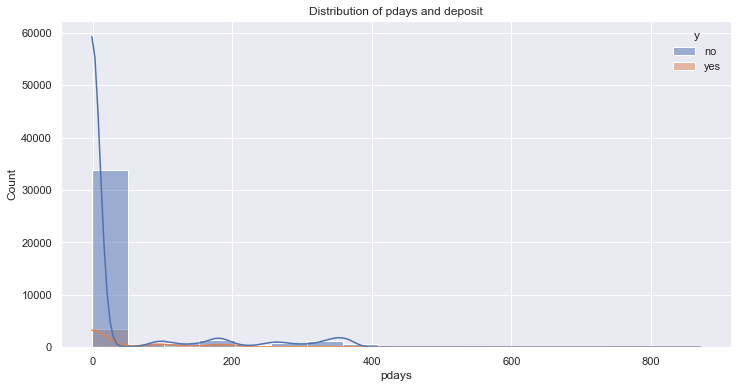

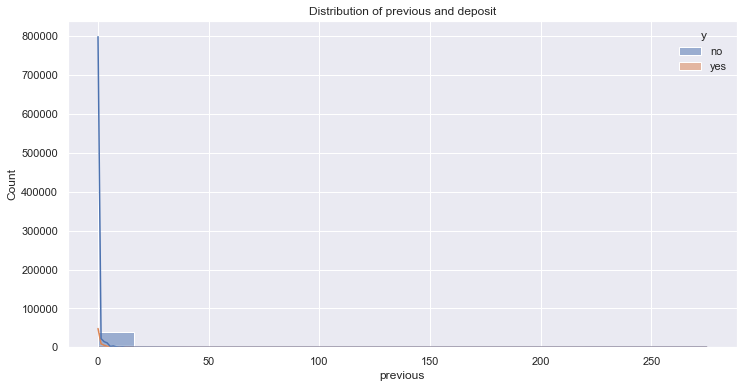

In [6]:
for c in df.columns:
    if df[c].dtype == 'int64' or df[c].dtype == 'float64':
        sns.histplot(x = df[c], hue = df['y'], kde = True).set(title='Distribution of {} and deposit'.format(c))
        sns.set(rc={'figure.figsize':(12,6)})
        plt.show()

# Outliers

When the data is (approximately) normally distributed, we can use the Z-score treatment to deal with outliers. 

However, as we can see from the distributions, most our columns have skewed distributions. So we can try using the IQR method. 

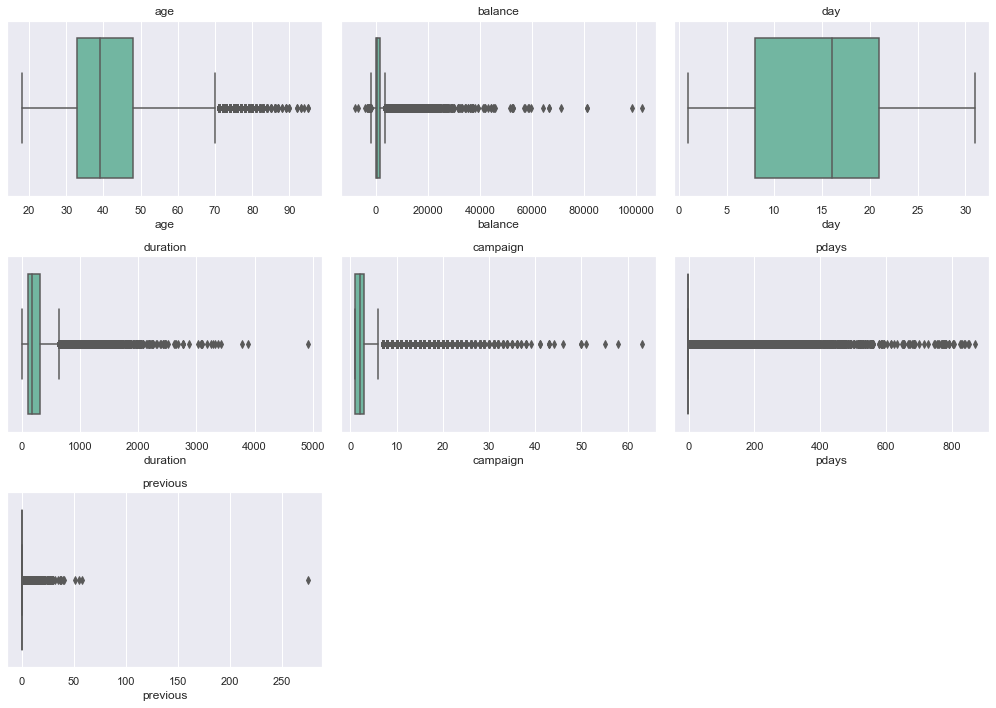

In [7]:
# plot in a grid
plt.figure(figsize=(14,10))
i = 1
for c in df.columns:
    if df[c].dtype == 'int64' or df[c].dtype == 'float64':
        plt.subplot(3, 3, i)
        i+=1
        sns.boxplot(x = df[c], hue = df['y'], palette='Set2')
        plt.title(f'{c}')
plt.tight_layout()        
plt.show()

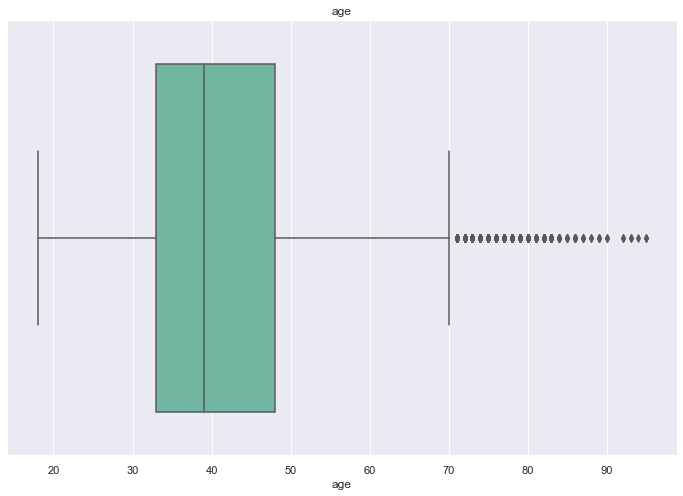

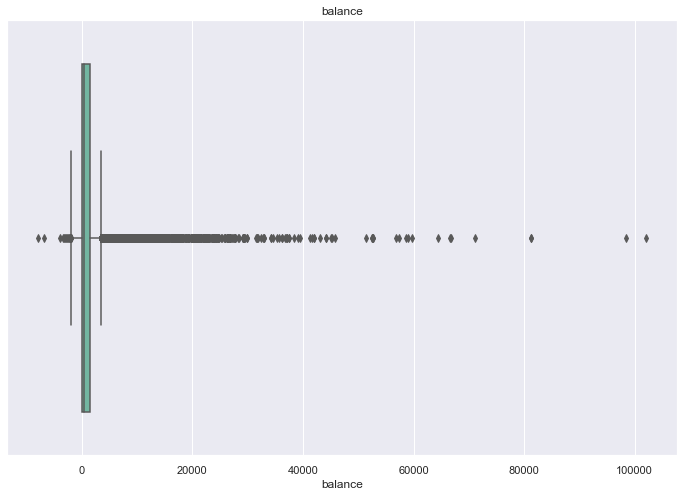

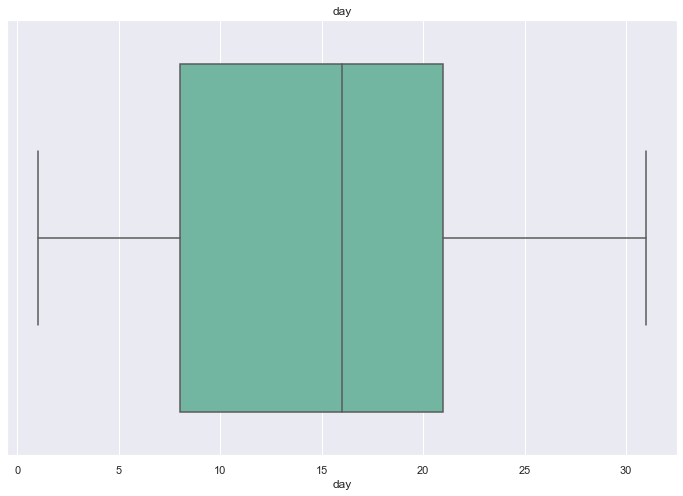

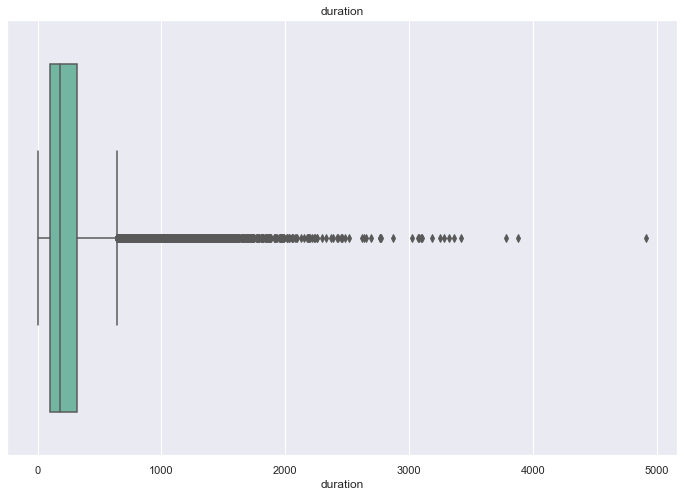

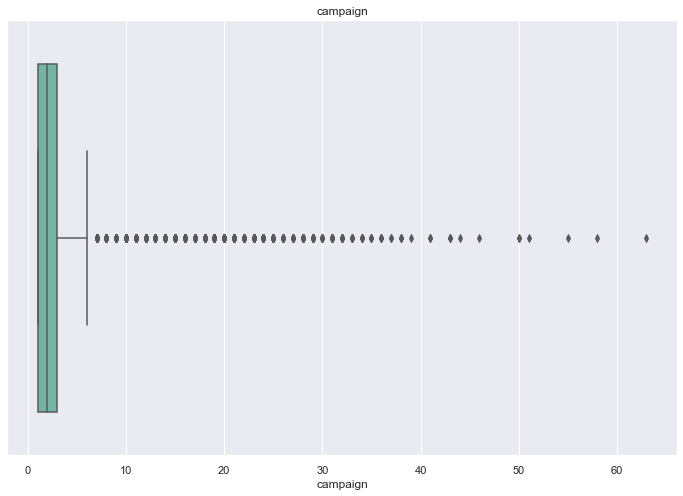

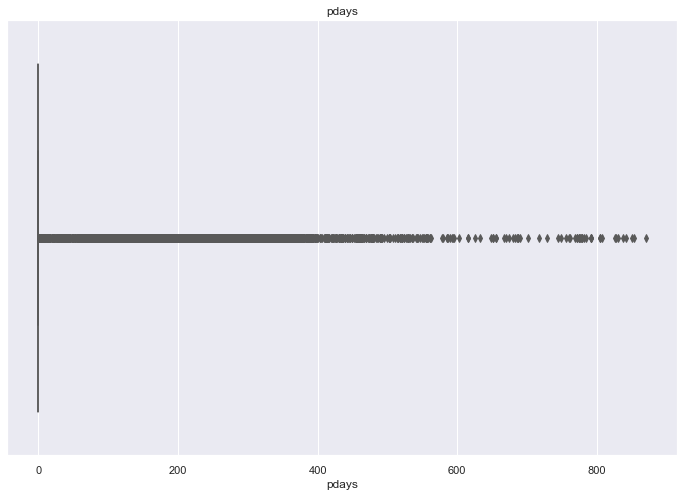

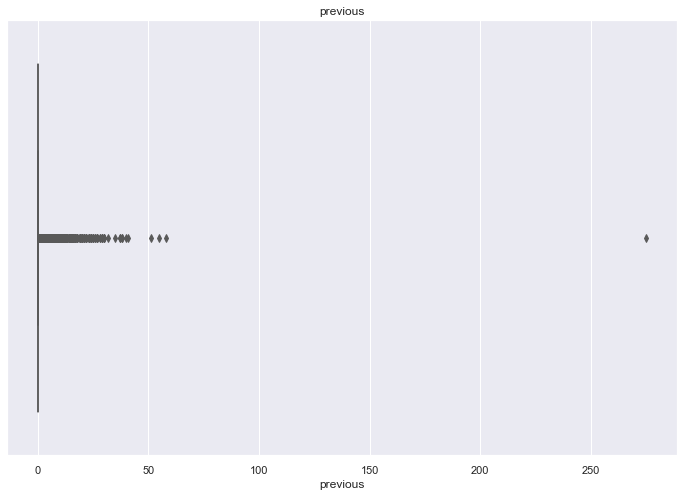

In [8]:
# plot seperately
for c in df.columns:
    if df[c].dtype == 'int64' or df[c].dtype == 'float64':
        plt.figure(figsize=(12,8))
        sns.boxplot(x = df[c], hue = df['y'], palette='Set2')
        plt.title(f'{c}')
        plt.show()


In [9]:
'''write functions to be utilised later to deal with outliers'''

# write a function to find outliers using IQR method
def iqr(df,col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return lower_bound, upper_bound
# write a function to trim outliers
def trim(df,col):
    lower_bound, upper_bound = iqr(df,col)
    df_trim = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
    return df_trim
# write a function to cap outliers
def cap(df,col):
    lower_bound, upper_bound = iqr(df,col)
    df_cap = df.copy()
    df_cap[col] = df_cap[col].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
    return df_cap
# write a function to replace outliers with threshold
def thresh(df, col, thresh):
    df_thresh = df.copy()
    df_thresh[col] = df_thresh[col].apply(lambda x: thresh if x > thresh else x)
    return df_thresh
# write a function to replace outliers with median
def replace_median(df,col):
    lower_bound, upper_bound = iqr(df,col)
    df_replace = df.copy()
    median = df_replace[col].median()
    df_replace[col] = df_replace[col].apply(lambda x: median if x < lower_bound or x > upper_bound else x)
    return df_replace
# write a function to replace outliers with mean
def replace_mean(df,col):
    lower_bound, upper_bound = iqr(df,col)
    df_replace = df.copy()
    mean = df_replace[col].mean()
    df_replace[col] = df_replace[col].apply(lambda x: mean if x < lower_bound or x > upper_bound else x)
    return df_replace

# Deciding on method for Outliers

We have to decide how to deal with the outliers. In general, when dealing with quantities like bank "balance" or income that have a wide spread, it is common to check if the log-distribution is helpful in lessoning the effect of outliers. 


For the "Duration" column, as already mentioned in the introduction, since it is the duration of last contact, it is only known when the outcome 'y' also becomes known. Thus we don't need to use this in our predictive model.  


For the "age" column, we can tell that the distribution appears bi-modal or tri-modal but it is not heavily affected by outliers. Also, we don't want to lose meaningful information by forcing it to fit a distribution.


The "days" column is evenly distributed and there are no outliers. 


The "camapign" column tells us how many times the client was contacted during the campaign. As we can see from the code below, only 3% of the values are above 10, and only 1% are above 15. In this case it might not be a bad idea to use capping to impute these outliers. We may set the threshold to 10 or 15 and compare results.


The "pdays" columns tells us how many days have passed since last contact. The value 999 means there was no last contact. By analysing the column, we can see that there is no observation of 999, and infact 82% of the observations are -1. So there is an issue in data description and we will be taking -1 as 999. 


Lastly, the "previous" column tells us how many times the client was contacted. As we can see from the analysis below, only 2% of clients were contacted more than 5 times. Capping might be the way to deal with outliers here, or better solution might be to create bins of variable length. 


It can be seen from the heat map that pdays and previous are highly correlated. It might be worth considering to drop on of these columns. 

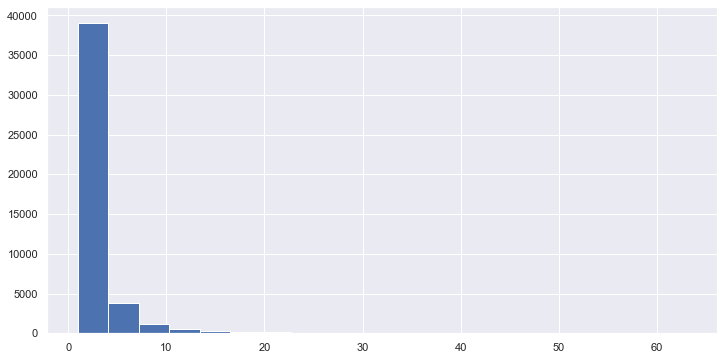

Unique values in campaign --> 
[ 1  2  3  5  4  6  7  8  9 10 11 12 13 19 14 24 16 32 18 22 15 17 25 21
 43 51 63 41 26 28 55 50 38 23 20 29 31 37 30 46 27 58 33 35 34 36 39 44]
Proportion of values above 10 --> 0.03
Proportion of values above 15 --> 0.01
Proportion of values above 20 --> 0.01


In [10]:
'''analyse campaign column'''

plt.hist(df['campaign'], bins=20)
plt.show()
camp = df['campaign'].unique()
print(f'Unique values in campaign --> ')
print(camp)
# find proportion of values above thresholds
for i in [10,15,20]:
    print(f'Proportion of values above {i} --> {round(len(df[df["campaign"] > i])/len(df),2)}')
    

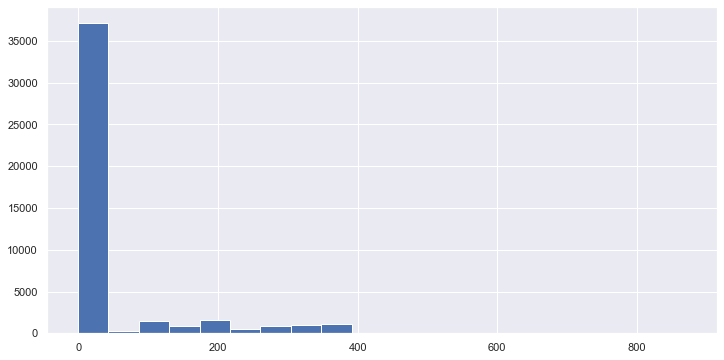

Unique values in pdays --> 
Number of unique values --> 48
Max value --> 63
Min value --> 1
Number of values equal to 999 --> 0
Number of values equal to 0 --> 0
Number of values equal to -1 --> 36954
Proportion of values equal to -1 --> 0.82


In [11]:
'''analyse pdays column'''

plt.hist(df['pdays'], bins=20)
plt.show()
unq = df['pdays'].unique()
print(f'Unique values in pdays --> ')
# print(unq)
print(f'Number of unique values --> {len(camp)}')
print(f'Max value --> {max(camp)}')
print(f'Min value --> {min(camp)}')
print(f'Number of values equal to 999 --> {len(df[df["pdays"] == 999])}')
print(f'Number of values equal to 0 --> {len(df[df["pdays"] == 0])}')
print(f'Number of values equal to -1 --> {len(df[df["pdays"] == -1])}')
print(f'Proportion of values equal to -1 --> {round(len(df[df["pdays"] == -1])/len(df),2)}')
# find proportion of values above thresholds
# for i in [10,15,20]:
#     print(f'Proportion of values above {i} --> {round(len(df[df["campaign"] > i])/len(df),2)}')
    

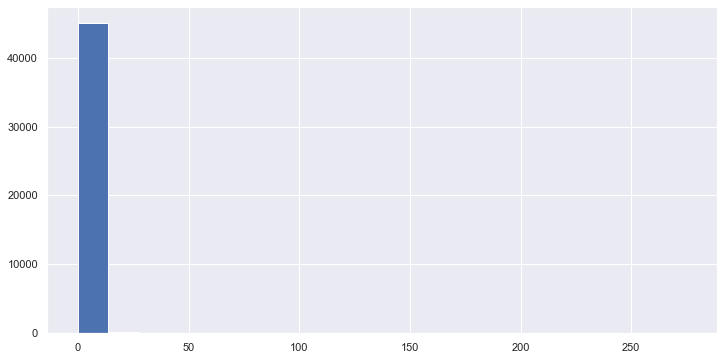

Unique values in previous --> 
[  0   3   1   4   2  11  16   6   5  10  12   7  18   9  21   8  14  15
  26  37  13  25  20  27  17  23  38  29  24  51 275  22  19  30  58  28
  32  40  55  35  41]
Proportion of values above 5 --> 0.024
Proportion of values above 10 --> 0.007
Proportion of values above 15 --> 0.002
Proportion of values above 20 --> 0.001
0      36954
1       2772
2       2106
3       1142
4        714
5        459
6        277
7        205
8        129
9         92
10        67
11        65
12        44
13        38
15        20
14        19
17        15
16        13
19        11
20         8
23         8
18         6
22         6
24         5
27         5
21         4
29         4
25         4
30         3
38         2
37         2
26         2
28         2
51         1
275        1
58         1
32         1
40         1
55         1
35         1
41         1
Name: previous, dtype: int64


In [12]:
'''analyse previous column'''

plt.hist(df['previous'], bins=20)
plt.show()
unq = df['previous'].unique()
print(f'Unique values in previous --> ')
print(unq)
# find proportion of values above thresholds
for i in [5,10,15,20]:
    print(f'Proportion of values above {i} --> {round(len(df[df["previous"] > i])/len(df),3)}')
print(df['previous'].value_counts())
    

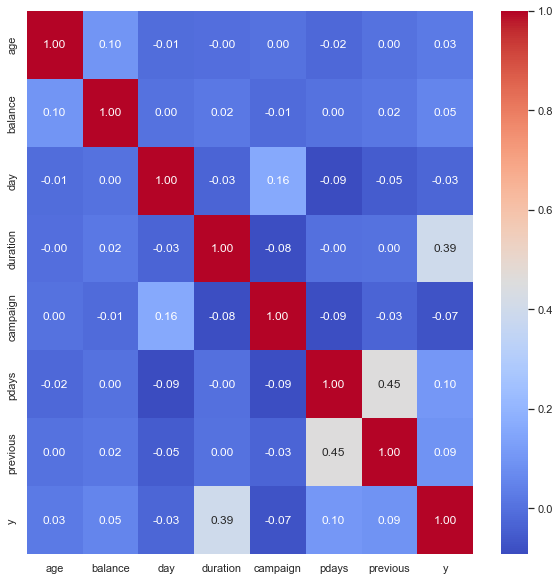

In [13]:
# Convert target variable into numeric
data = df.copy()
data.y = data.y.map({'no':0, 'yes':1}).astype('uint8')
# heatmap of correlations between numerical variables
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

# Balance

Before using the log transform, let us check for 0's. The code below shows that approximately 8% of the values in the "balance" column are 0. Since we do not want to lose this data, we can use the transformation log(x+1).

This will ensure that the 0's map to 0' and that the distribution of the data is not disturbed too much.

As we can see from the plots below, the distribution of the data has been greatly imporved by applying the log transformation. We can compare both the histograms and the boxplots. It is much closer to normal.

In [51]:
# check for 0'set
print('Number of zeros = {}'.format(len(data[data['balance'] == 0])))
print('Proportion of zeros = {}'.format(len(data[data['balance'] == 0])/len(data)))

Number of zeros = 3514
Proportion of zeros = 0.07772444759018823


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


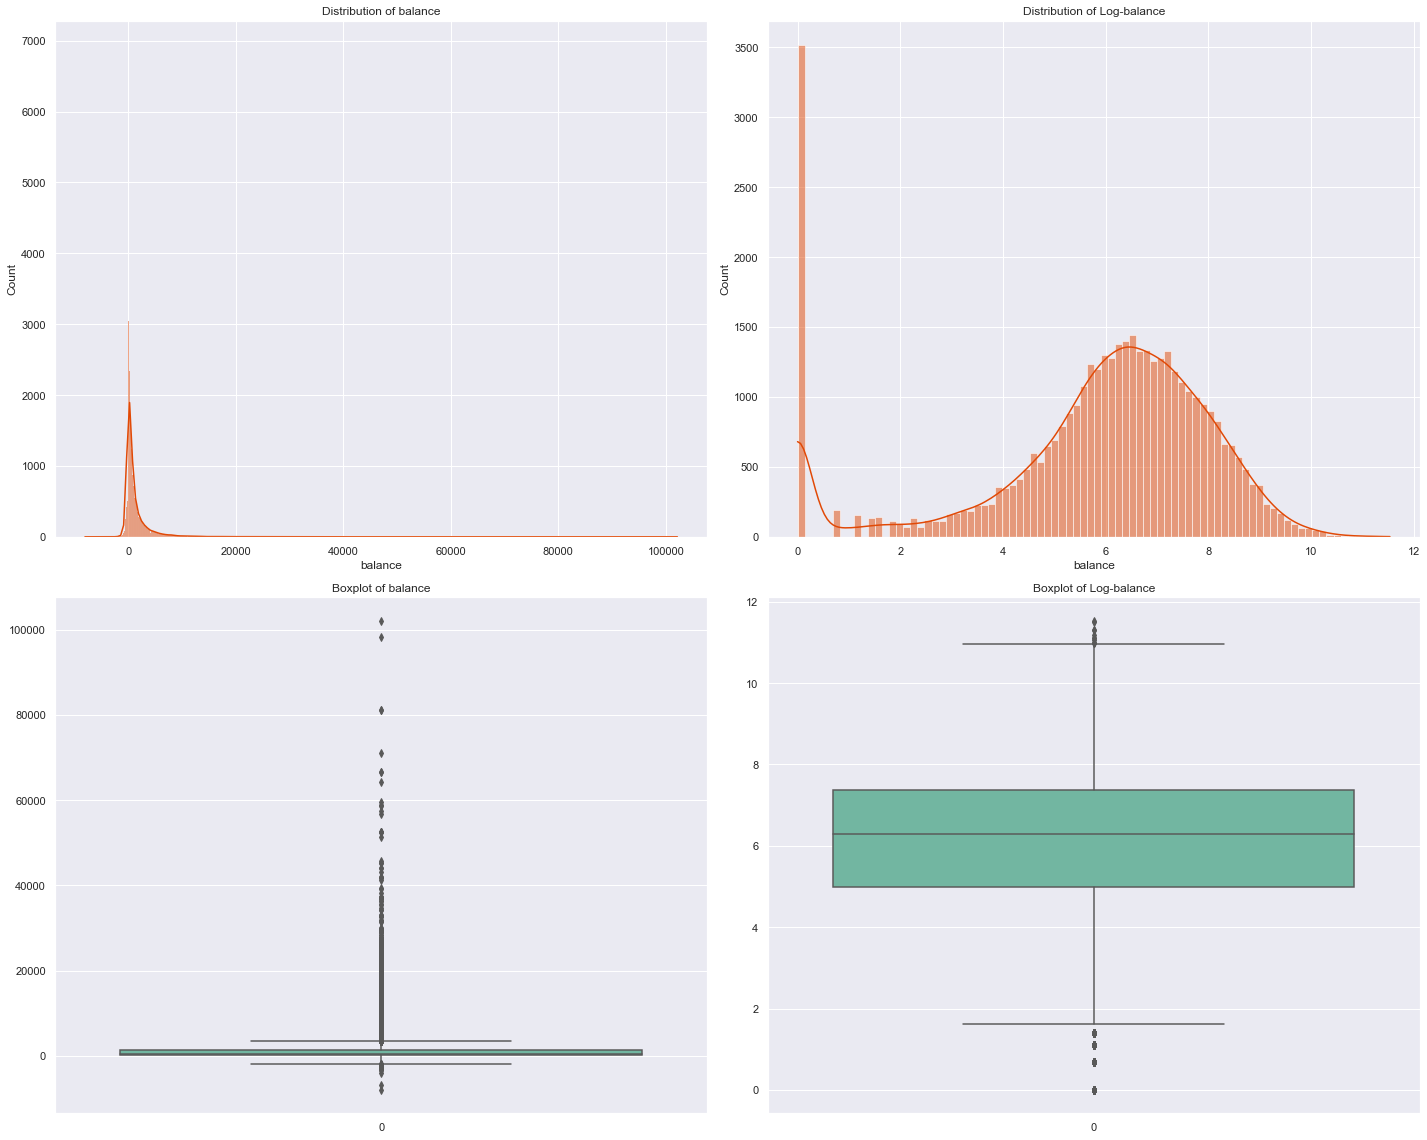

In [50]:
fig, (ax1, ax2) = plt.subplots(2,2, figsize=(20,16))
sns.histplot(data['balance'], kde=True, color='#E14906', ax = ax1[0])
ax1[0].set_title('Distribution of balance')
sns.histplot(np.log(data['balance']+1), kde=True, color='#E14906', ax = ax1[1])
ax1[1].set_title('Distribution of Log-balance')
sns.boxplot(data['balance'], palette='Set2', ax = ax2[0])
ax2[0].set_title('Boxplot of balance')
sns.boxplot(np.log(data['balance']+1), palette='Set2', ax = ax2[1])
ax2[1].set_title('Boxplot of Log-balance')
plt.tight_layout()
plt.show()

# Campaign

The plots show some improvement after applying the 'thresh' function. However, it seems like the threshold can be further lowered from 10 to about 6. In fact the plot with thresh = 6 does about the same thing as using 'cap' function with IQR.

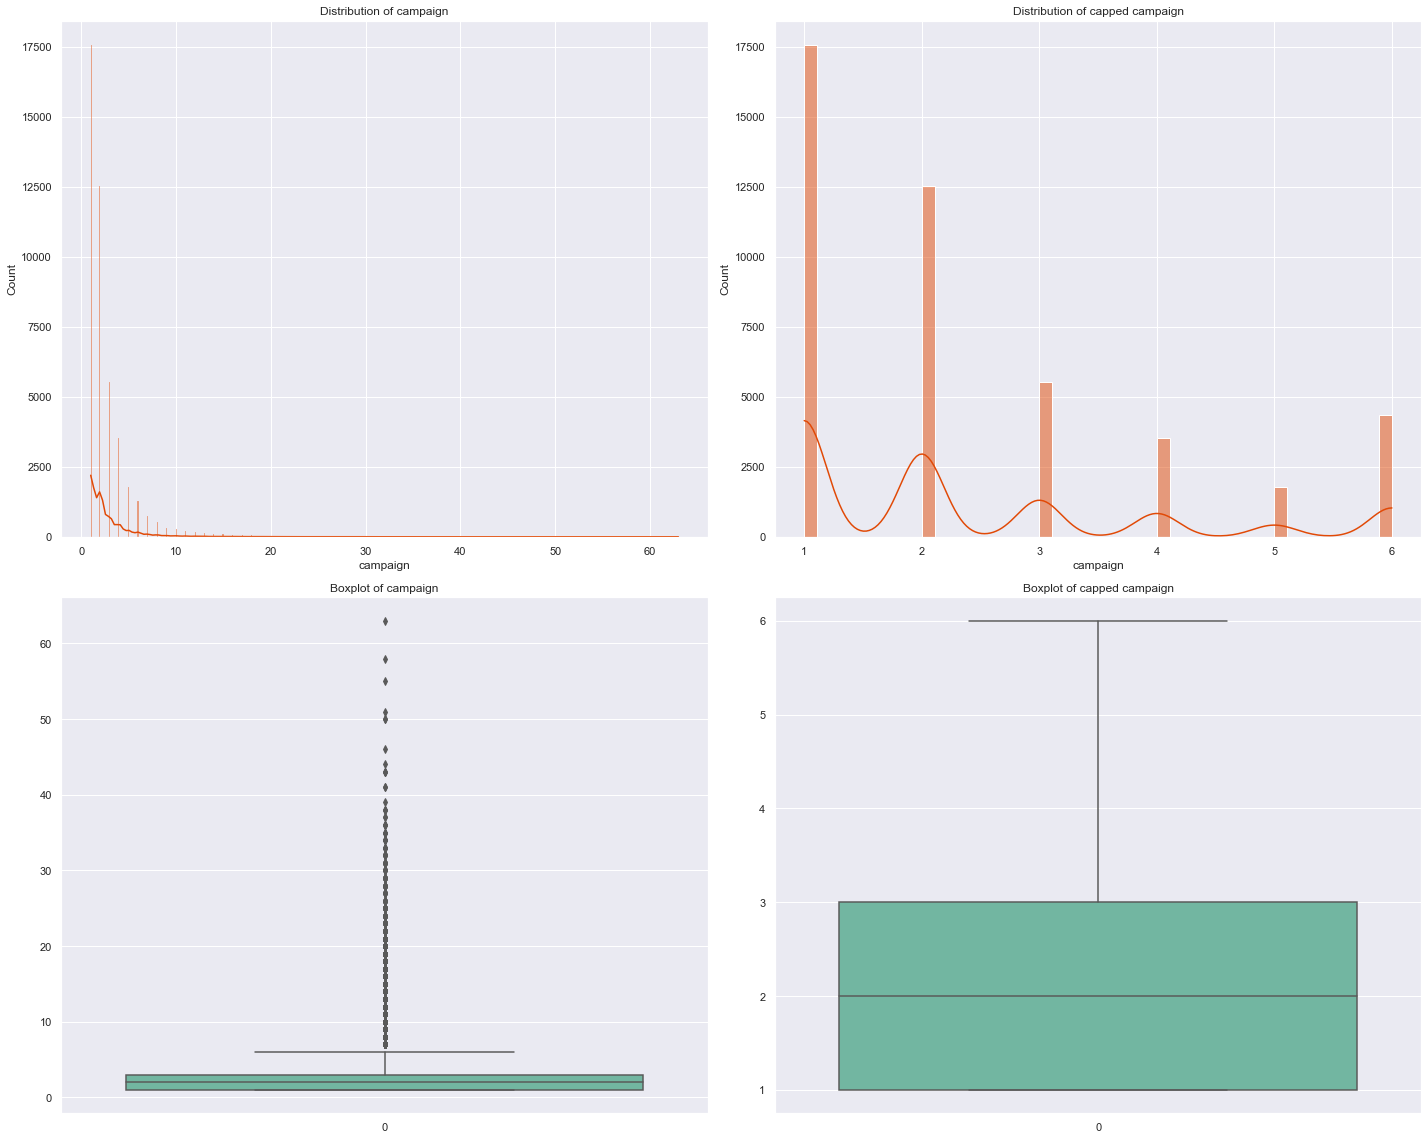

In [15]:
# use thresh function to cap outliers in campaign column
data_camp = thresh(data,'campaign', 6)  # try threshold of 10, 15, 20
# plot histograms and boxplots 
fig, (ax1, ax2) = plt.subplots(2,2, figsize=(20,16))
sns.histplot(data['campaign'], kde=True, color='#E14906', ax = ax1[0])
ax1[0].set_title('Distribution of campaign')
sns.histplot(data_camp['campaign'], kde=True, color='#E14906', ax = ax1[1])
ax1[1].set_title('Distribution of capped campaign')
sns.boxplot(data['campaign'], palette='Set2', ax = ax2[0])
ax2[0].set_title('Boxplot of campaign')
sns.boxplot(data_camp['campaign'], palette='Set2', ax = ax2[1])
ax2[1].set_title('Boxplot of capped campaign')
plt.tight_layout()
plt.show()

# Pdays

Let us start by changing the integer for no contact from -1 to 999.

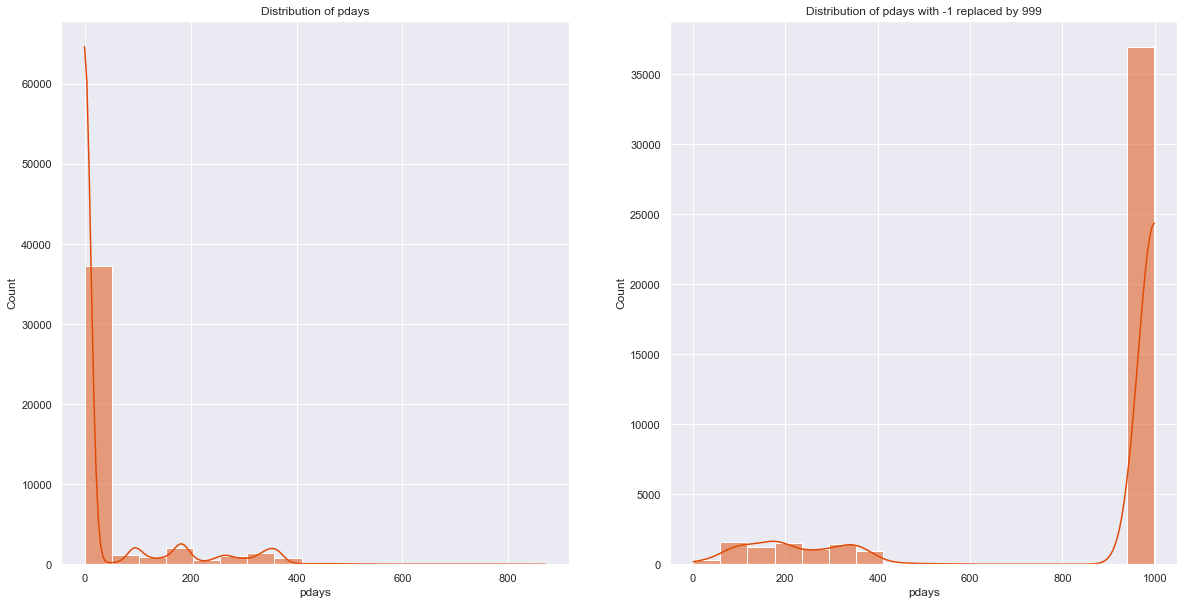

In [21]:
# change -1 to 999 in pdays column
data_pdays = data.copy()
data_pdays['pdays'] = data_pdays['pdays'].apply(lambda x: 999 if x == -1 else x)
# plot histograms and boxplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
sns.histplot(data['pdays'], kde=True, color='#E14906', ax = ax1)
ax1.set_title('Distribution of pdays')
sns.histplot(data_pdays['pdays'], kde=True, color='#E14906', ax = ax2)
ax2.set_title('Distribution of pdays with -1 replaced by 999')
plt.show()


In [45]:
# check correlation with target variable before and after
print('Correlation of original --> {}'.format(data['pdays'].corr(data['y'])))
print('Correlation of modified --> {}'.format(data_pdays['pdays'].corr(data_pdays['y'])))
print("")
print('Proportion of customers who were never contacted  = {}'.format(len(df[df['pdays']==-1])/len(df)))

Correlation of original --> 0.10362149401628687
Correlation of modified --> -0.17889771162752197

Proportion of customers who were never contacted  = 0.8173674548229414


As we can see from the plots and the correlation checks, the data, after changing -1 to 999, seems to present a more realistic picture, in that there is now a negative correlation between pdays and response.

This makes sense as customers with pdays = 999, i.e; customers who have never been contacted would be more likely to say no (y = 0). 

We can also see that the majority (82%) of customers were never contacted. Let us try to exclude these customers from the dataset and try to see if there if a relationship between number of days since last contact and response.

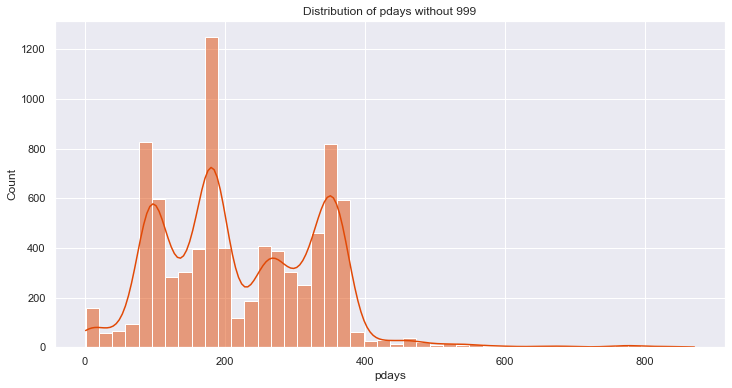

In [22]:
# check distribution of pdays without 999
sns.histplot(data_pdays[data_pdays['pdays'] != 999]['pdays'], kde=True, color='#E14906').set_title('Distribution of pdays without 999')
plt.show()

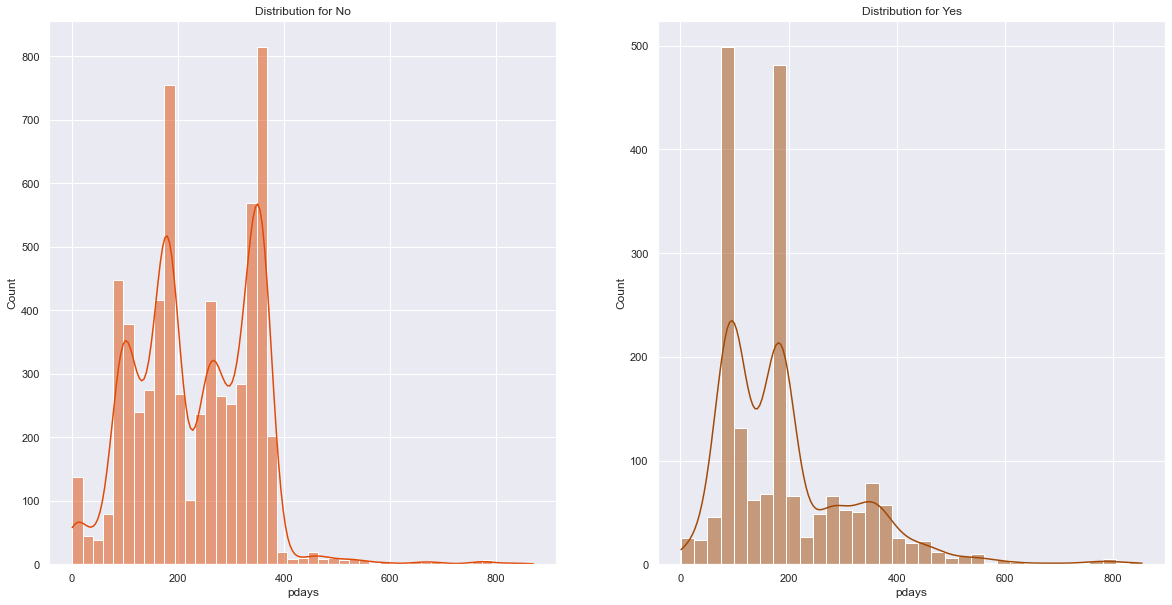

In [53]:
# check distribution split by response
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
pdays_no = data_pdays[(data_pdays['pdays']!=999) & (data_pdays['y']==0)]
pdays_yes = data_pdays[(data_pdays['pdays']!=999) & (data_pdays['y']==1)]
sns.histplot(pdays_no['pdays'], kde=True, color='#E14906', ax = ax1).set_title('Distribution for No')
sns.histplot(pdays_yes['pdays'], kde=True, color='#A14906', ax = ax2).set_title('Distribution for Yes')
plt.show()

In [44]:
## check proportions and value counts
no_999 = data_pdays[data_pdays['pdays']!=999]
print('ORIGINAL -->') 
print(data['y'].value_counts())
print(f'Proportion of no --> {round(data["y"].value_counts()[0]/len(data),2)}')
print(f'Proportion of yes --> {round(data["y"].value_counts()[1]/len(data),2)}')
print('Correlation with target --> {}'.format(data['pdays'].corr(data['y'])))
print("")
print('MODIFIED -->')
print(no_999['y'].value_counts())
print(f'Proportion of no --> {round(no_999["y"].value_counts()[0]/len(no_999),2)}')
print(f'Proportion of yes --> {round(no_999["y"].value_counts()[1]/len(no_999),2)}')
print('Correlation with target --> {}'.format(no_999['pdays'].corr(no_999['y'])))


ORIGINAL -->
0    39922
1     5289
Name: y, dtype: int64
Proportion of no --> 0.88
Proportion of yes --> 0.12
Correlation with target --> 0.10362149401628687

MODIFIED -->
0    6352
1    1905
Name: y, dtype: int64
Proportion of no --> 0.77
Proportion of yes --> 0.23
Correlation with target --> -0.15220589501266893


As we can see from the value counts and proportions, the proportion of "yes" response increases and "no" decreases when we remove the 999 cases. 

Also, as can be seen from the correlations, when 999 cases are not considered, pdays has a small negative correlation with response. This means that as time since last contact increases, the chances of the customer responding "yes" will decrease. This makes more realistic sense. 

We wanted to verify that the negative correlation present in the modified data was not induced, i.e; it was a property of the data. We have removed the extreme case (999) and checked that the correlation holds true for the rest of the data as well. In fact there is only a slight drop in magnitude (from -0.17 to -0.15).

In [58]:
all_999 = data_pdays[data_pdays['pdays']==999]
len(all_999[all_999['y']==1])/len(all_999)

0.09157330735509012

In [56]:
all_999['campaign'].value_counts()

1     13529
2     10229
3      4608
4      3097
5      1508
6      1128
7       638
8       486
9       303
10      256
11      189
12      148
13      131
14       92
15       83
16       78
17       69
18       51
19       44
20       43
21       35
22       23
25       22
23       22
24       20
29       16
28       16
26       13
31       12
27       10
32        9
30        8
33        6
34        5
36        4
35        4
43        3
38        3
37        2
50        2
41        2
46        1
58        1
55        1
63        1
51        1
39        1
44        1
Name: campaign, dtype: int64